In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import cvxpy

## Introduction to Portfolio Theory

In classical portfolio theory periodic returns are normally distributed. We will assume daily returns of two stocks $R_A$ and $R_B$ denote prices of two stocks $A$ and $B$, respectively, such that they are jointly normally distributed with the following properties. Marginally, 
$$R_A \sim N(\mu_A,\sigma_A^2) \text{, and } R_B \sim N(\mu_B,\sigma_B^2),$$
and, jointly, their covariance and correlation are
$$\sigma_\text{AB} = \text{Cov}(R_A,R_B) \text{, and } \rho_\text{AB} = \frac{\sigma_\text{AB}}{\sigma_A\sigma_B}$$

If we consider managing a portfolio consisting of these two stocks, then the return for the portfolio $R_p$ is 
$$R_p = R_A x_A + R_B x_B,$$
where $x_A$ and $x_B$ are fixed proportions of portfolio such that $x_A + x_B = 1$.

What are the properties of $R_p$? We know $R_p$ is also normally distributed with following mean and variance:
$$ 
\mu_p = \text{E}(R_p) = \text{E}(R_B)\, x_A + \text{E}(R_B)\, x_B = \mu_A x_A + \mu_B x_B\\
\sigma_p^2 = \text{Var}(R_p) = \text{E}\left((R_p - \text{E}(R_p))^2\right) = \sigma_A^2\,x_A^2 + \sigma_B^2\,x_B^2 + 2\sigma_{AB}x_A x_B.
$$
Note that $\sigma_{AB} = \rho_{AB}\sigma_A\sigma_B$.

Finally, the distribution of the portfolio return is
$$ R_p \sim N(\mu_p, \sigma_p^2) $$

Let's simulate behavior of returns $R_A$, $R_B$, and $R_p$ (portfolio weight distributed evenly): i.e. $x_A = x_B = 0.5$. Also, choose some parameters for our two stocks.

In [2]:
x = pd.Series({'A': 0.5, 'B': 0.5})
mu = pd.Series({'A':0.15, 'B':0.1})
sig = pd.Series({'A':0.1, 'B':0.05})

## correlation between stocks
rhoAB = -0.15

### Calculate theoretical portfolio returns

Calculate the volatility ($\sigma^2$) and expected returns ($\mu$):

In [3]:
mu['p'] = mu.A * x.A + mu.B * x.B
sig['p'] = np.sqrt((sig.A**2 * x.A**2) + (sig.B**2 * x.B**2) + (2 * rhoAB * sig.A *sig.B * x.A * x.B))

[one for one in zip(sig**2,mu)]

[(0.010000000000000002, 0.15),
 (0.0025000000000000005, 0.1),
 (0.0027500000000000007, 0.125)]

### Generate random returns

Generate random observations from bivariate normal distribution specified by 

RA: mean is 0.1519908708765201 , std dev is 0.10105293262926675
RB: mean is 0.09873291782450459 , std dev is 0.049730986724841206
Correlation between RA and RB is -0.09651296845434312


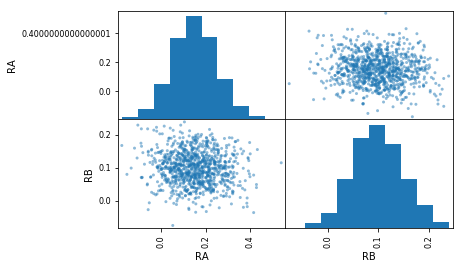

In [4]:
param_mu = [mu.A, mu.B]
param_sigma = [[sig.A**2, rhoAB*sig.A*sig.B],
               [rhoAB*sig.A*sig.B, sig.B**2]]

R_AB = np.random.multivariate_normal(param_mu, param_sigma, 1000)
RA = R_AB[:,0]
RB = R_AB[:,1]

print('RA: mean is', RA.mean(), ', std dev is', RA.std())
print('RB: mean is', RB.mean(), ', std dev is', RB.std())
print('Correlation between RA and RB is', np.corrcoef(RA, RB)[1,0])

pd.plotting.scatter_matrix(pd.DataFrame(R_AB, columns=['RA', 'RB']));

Volatility of returns are:

In [5]:
sig

A    0.10000
B    0.05000
p    0.05244
dtype: float64

Note that $\mu_p$ is a simple average of the returns; however, $\sigma_p^2 < 0.5\sigma_A^2 + 0.5\sigma_B^2$. This means that volatility is less than if $A$ and $B$ were independent. This owes to the characteristic that $\rho<0$, so that the cross-term subtracts from $\sigma_p^2$. In fact, this is theoretical basis for the advantage of diversification.

### Efficient frontier of portfolios

What happens if we change the proportion of the portfolios $x_A$ and $x_B$? For a range of possibilities, we compute the resulting return $\mu_p$ and volatility $\sigma_p^2$.

In [6]:
xa = np.linspace(-1, 2, num=101)
pf = pd.DataFrame({'xa':xa, 'xb':1-xa})

pf['mu'] = mu.A * pf.xa + mu.B * pf.xb
pf['sig2'] = ((sig.A**2 * pf.xa**2) + (sig.B**2 * pf.xb**2) + (2 * rhoAB * sig.A *sig.B * pf.xa * pf.xb))

#### Long and short positions

Note that `xa` is allowed to be negative. A positive $x_A$ value indicates what is called a _long position_ for stock A and indicates a purchase. On the otherhand, a negative $x_A$ indicates a _short position_ stock A and indicates a sale. The sale of A allows for higher long positions on other stocks.

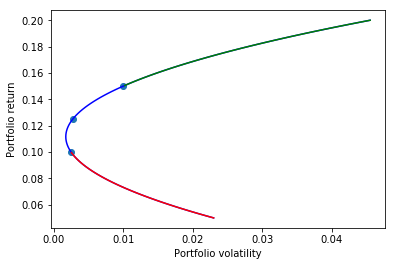

In [7]:
p = plt.subplot(1,1,1)
plt.plot(pf.sig2, pf.mu, color='b')
plt.plot(pf.sig2[pf.xa<0], pf.mu[pf.xa<0], color='r')
plt.plot(pf.sig2[pf.xb<0], pf.mu[pf.xb<0], color='g')
plt.scatter(sig**2, mu)
p.set_xlabel('Portfolio volatility')
p.set_ylabel('Portfolio return')
plt.show(p)

Above plot is called the efficient frontier. The line represents the lower boundary of achievable volatility for each level of portfolio return using component stocks. Two stocks $A$ and $B$ are shown as dots in the interior of the parabola, and the dot on the parabola is the return and volatility of a portfolio in which $x_A = x_b = 0.5$.

#### Minimum variance portfolio (MVP)

What is the point at the tip of the parabola? This point indicates what is called the minimum variance portfolio that, regardless of the return, has the minimum volatility. Minimum variance portfolio (MVP) has the minimum volatility of any portfolio achievable.

It can be shown that minimum variance portfolio would have the following allocation $x_A$:

$$x_A = \frac{\sigma_B^2-\sigma_\text{AB}^2}{\sigma_A^2 + \sigma_B^2 – \sigma_\text{AB}^2}$$

In [8]:
mvp_A = (sig.B**2 - rhoAB * sig.A *sig.B )/(sig.A**2 + sig.B**2 - rhoAB * sig.A *sig.B ) 
mvp_B = 1 - mvp_A
mvp_mu = mu.A * mvp_A + mu.B * mvp_B 
mvp_sig2 = ((sig.A**2 * mvp_A**2) + (sig.B**2 * mvp_B**2) + (2 * rhoAB * sig.A *sig.B * mvp_A * mvp_B))
mvp_mu, mvp_sig2

(0.11226415094339623, 0.0017479530081879677)

Plot the minimum variance portfolio:

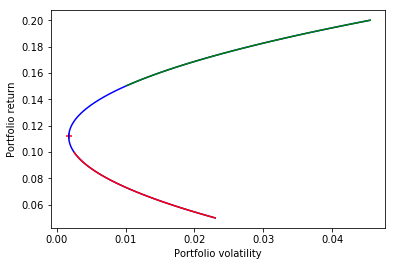

In [9]:
p = plt.subplot(1,1,1)
plt.plot(pf.sig2, pf.mu, color='b')
plt.plot(pf.sig2[pf.xa<0], pf.mu[pf.xa<0], color='r')
plt.plot(pf.sig2[pf.xb<0], pf.mu[pf.xb<0], color='g')
plt.scatter(mvp_sig2, mvp_mu, color='r', marker='+')
p.set_xlabel('Portfolio volatility')
p.set_ylabel('Portfolio return')
plt.show(p)

The mathematical problem to solve for the minimum variance portfolio can be stated as follows:
$$ \min_{x_A,x_B}\ \ \sigma_p^2 = \sigma_A^2 x_A^2 + \sigma_B^2 x_B^2 + \sigma_{AB} x_A x_B\\
\text{such that }x_A + x_B = 1$$
Here, $\sigma_p^2 = \sigma_A^2 x_A^2 + \sigma_B^2 x_B^2 + \sigma_{AB} x_A x_B$ is called the objective function, and $x_A + x_B = 1$ is called the constraint.

The constraint has to be satisfied exactly, and objective wants to be minimized with the freedom of changing the values of $x_A$ and $x_B$.

### Using `cvxpy` for numerical optimization

Calculating analytical solutions is not always possible. There are ways to compute solutions numerically. Although out of scope of our class, a large field in applied math called optimization. The tools from this area allow us to compute solutions for problems such as the one we have here. (For more information, visit the 

### Higher dimensional portfolios

In higher dimensions, the portfolio equantion is written in terms of vectors and matrices. For example, suppose we construct a portfolio consisting of $s$-assets. The portfolio allocation can be written as,
$$\mathbf{1}^\intercal x = 1,$$
where $x$ is an $s$-vector whose sum adds up to 1: i.e., $x_1 + x_2 + \cdots + x_s = 1$.

The portfolio volatility in matrix-vector form looks like:
$$
\begin{pmatrix}x_1 & x_2 & \cdots & x_s\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1s}\\
\sigma_{21} & \sigma_2^2 & \cdots & \sigma_{2s}\\
\vdots & \vdots & & \vdots \\
\sigma_{s1} & \sigma_{s2} & \cdots & \sigma_s^2\\
\end{pmatrix}
\begin{pmatrix}x_1 \\ x_2 \\ \vdots \\ x_s\end{pmatrix}.
$$
To verify the two stock example result, we check $\sigma_p^2$:
$$
\sigma_p^2 = \begin{pmatrix}x_1 & x_2\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 & \sigma_{12}\\
\sigma_{21} & \sigma_2^2\\
\end{pmatrix}
\begin{pmatrix}x_1 \\ x_2\end{pmatrix} = 
\begin{pmatrix}x_1 & x_2\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 x_1 + \sigma_{12} x_2\\
\sigma_{21} x_1 + \sigma_2^2 x_2\\
\end{pmatrix} = 
\sigma_1^2 x_1^2 + \sigma_2^2 x_2^2 + \sigma_{12} x_1 x_2,
$$
which matches the result from before.

With this notation, we can re-write the problem.

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mathbf{1}^\intercal x = 1,$$

It can be shown that the optimal solution to this problem is,
$$ x^* = (\mathbf{1}^\intercal\Sigma^{-1}\mathbf{1})^{-1}\Sigma^{-1}\mathbf{1} $$.

There are many variations of this problem. In fact the minimum variance portfolio is special case of a more general problem

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mu^\intercal x\geq \mu^* \text{, and } \mathbf{1}^\intercal x = 1,$$

Note that in all of the above problems, the measure of $\mu^*$, expected returns, and covariance matrix have to be provided. In practice, these quantities are estimated from data.

### Download data from Quandl

Use the Quandl API to download some stock data. In this example, we will use the constituent stocks from the [Dow Jones Industrial Average](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average) to form our portfolio.

In [10]:
import quandl
import myapikeys as m

quandl.ApiConfig.api_key = m.apikeys['quandl']

In [11]:
## download the ticker metadata
!wget -q https://www.quandl.com/api/v3/databases/WIKI/metadata?api_key={m.apikeys['quandl']} -O data/tickers.zip
## unzip inside data directory
!unzip -o -d data data/tickers.zip

Archive:  data/tickers.zip
  inflating: data/WIKI_metadata.csv  


In [12]:
symbols = pd.read_csv('data/WIKI_metadata.csv')
symbols.set_index('code', inplace=True)
symbols.drop('description', axis=1, inplace=True)
print('number of stocks: ', len(symbols.index))
print('earliest date: ', symbols['from_date'].min())
print('  latest date: ', symbols['to_date'].max())

number of stocks:  3199
earliest date:  1962-01-02
  latest date:  2018-03-27


### Dow Jones Industrial Average

- 30 large publicly owned companies in the US

In [13]:
dowjones_components = [
    'AAPL','AXP','BA','BAC','CAT',
    'CSCO','CVX','DD','DWDP','DIS','GE',
    'HD','HPQ','IBM','INTC','JNJ',
    'JPM','KO','MCD','MMM',
    'MRK','MSFT','PFE','PG','T',
    'TRV','UTX','VZ','WMT','XOM']

symbols.loc[dowjones_components]

,name,refreshed_at,from_date,to_date
code,,,,
AAPL,"Apple Inc (AAPL) Prices, Dividends, Splits and...",2018-03-27 21:46:10,1980-12-12,2018-03-27
AXP,"American Express Co. (AXP) Prices, Dividends, ...",2018-03-27 21:46:10,1972-06-01,2018-03-27
BA,"The Boeing Co. (BA) Prices, Dividends, Splits ...",2018-03-27 21:46:10,1962-01-02,2018-03-27
BAC,"Bank of America Corp. (BAC) Prices, Dividends,...",2018-03-27 21:46:10,1986-05-29,2018-03-27
CAT,"Caterpillar Inc. (CAT) Prices, Dividends, Spli...",2018-03-27 21:46:10,1962-01-02,2018-03-27
CSCO,"Cisco Systems Inc. (CSCO) Prices, Dividends, S...",2018-03-27 21:46:10,1990-03-26,2018-03-27
CVX,"Chevron Corporation (CVX) Prices, Dividends, S...",2018-03-27 21:46:10,1970-01-02,2018-03-27
DD,"E.I. du Pont de Nemours and Co. (DD) Prices, D...",2017-08-31 21:48:17,1962-01-02,2017-08-31
DWDP,Untitled Dataset 2017-09-01 21:48:13,2018-03-27 21:46:10,2017-09-01,2018-03-27


### Data stopped updating

Note the data stopped updating in 2018. Web search shows this "free data" is no more: https://github.com/quantopian/zipline/issues/2145

In [14]:
data = quandl.get_table(
    'WIKI/PRICES', 
    qopts = { 'columns': ['ticker', 'date', 'adj_close'] }, 
    date = { 'gte': '2000-01-01', 'lte': '2018-05-01' },
    ticker = dowjones_components,
    paginate=True)

data.set_index('date', inplace=True)

In [15]:
data.head()

,ticker,adj_close
date,,
2018-03-27,XOM,73.70
2018-03-26,XOM,74.00
2018-03-23,XOM,72.89
2018-03-22,XOM,73.50
2018-03-21,XOM,75.04


Stock data can have irregularities such as missing data due stocks being added and removed from the index. Some examples are
* Alcoa Corp. (AA) was removed in 2013
* Apple (AAPL) was added in 2015
* E.I. du Pont de Nemours & Company (DD) was removed and replaced with Dow du Pont (DWDP) as a continuation in 2017

For simplicity the stocks we will use are based on the most recent DJIA constituent companies until 2017-08-31 so all 30 stocks can be included. Note that this is not the same as the Dow Jones Index throughout the time period since some symbols have entered the DJIA later than year 2000: e.g., Verizon was added in 2004.

We have set the index to be 'date' column. For the next line, unset datetime index in order to operate on the column:

In [16]:
data['ticker'].unique()

array(['XOM', 'WMT', 'VZ', 'UTX', 'TRV', 'T', 'PG', 'PFE', 'MSFT', 'MRK',
       'MMM', 'MCD', 'KO', 'JPM', 'JNJ', 'INTC', 'IBM', 'HPQ', 'HD', 'GE',
       'DWDP', 'DIS', 'DD', 'CVX', 'CSCO', 'CAT', 'BAC', 'BA', 'AXP',
       'AAPL'], dtype=object)

In [17]:
data_range = data.reset_index().groupby('ticker')['date'].agg([min, max])
data_range

,min,max
ticker,,
AAPL,2000-01-03,2018-03-27
AXP,2000-01-03,2018-03-27
BA,2000-01-03,2018-03-27
BAC,2000-01-03,2018-03-27
CAT,2000-01-03,2018-03-27
CSCO,2000-01-03,2018-03-27
CVX,2000-01-03,2018-03-27
DD,2000-01-03,2017-08-31
DIS,2000-01-03,2018-03-27


#### Subsetting date ranges with datetime index
Setting `date` column as the index is useful for time series data. The row index can be used to subset the data:

### Long to wide-format data

Since we will compute the covariance matrix, turn the data into long format

In [18]:
datawide = data.reset_index().pivot(index='date',columns='ticker',values='adj_close')
datawide = datawide['2000-01-03':'2017-08-31']
datawide.drop(['DWDP'], axis=1, inplace=True)
datawide

ticker,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,T,TRV,UTX,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,3.596463,36.138984,27.180308,14.971243,14.984244,44.665571,22.618476,34.188903,23.839401,29.005613,...,34.119980,38.796484,17.492344,33.642761,19.767236,20.993866,21.919553,24.211294,48.716786,24.854185
2000-01-04,3.293170,34.771563,27.139731,14.081128,14.790123,42.145127,22.618476,34.188903,25.235618,27.845388,...,32.919248,37.485073,16.839399,32.983714,18.610642,20.713948,21.021728,23.427678,46.893826,24.378112
2000-01-05,3.341362,34.593453,29.040120,14.235662,15.347834,42.475677,23.108007,35.666916,26.129196,27.797045,...,34.432776,37.881159,17.146668,32.701266,18.820932,20.917525,20.825329,24.211294,45.800050,25.590512
2000-01-06,3.052206,34.593453,29.121276,15.453389,15.908626,41.318752,24.003225,37.607794,25.235618,28.168317,...,34.498363,36.613017,17.728282,33.862443,18.502869,20.955695,21.589883,24.088096,46.441732,27.037774
2000-01-07,3.196784,35.076795,29.966645,15.048510,16.426281,43.756559,24.425141,37.676171,24.836699,29.258928,...,37.807945,37.092315,18.929921,36.561396,18.663579,21.789088,22.445622,23.909214,49.949107,26.958428
2000-01-10,3.140559,35.583153,29.547342,14.526186,15.887058,45.367990,23.767926,36.818819,28.626429,29.247326,...,36.703069,37.361920,18.896999,36.373097,18.925792,21.394658,22.666571,23.783184,49.037627,26.580743
2000-01-11,2.979917,35.905380,29.080698,14.217118,15.637474,44.004471,23.546150,36.161340,28.921629,29.295669,...,36.733340,36.403324,18.864078,36.969377,18.663579,21.152910,22.140502,23.559581,48.308443,26.898125
2000-01-12,2.801283,35.721250,29.121276,14.371652,15.908626,42.888865,23.462308,36.324395,26.879164,29.392354,...,37.555690,35.218394,19.275598,36.718312,17.682399,21.191081,22.642021,22.766808,47.440714,26.501398
2000-01-13,3.108431,35.905380,28.661395,14.699264,16.081178,43.880515,23.681379,36.029844,27.772743,29.730753,...,37.712088,35.884085,20.301654,36.090648,17.259476,21.630044,22.884013,22.587926,47.491757,27.117119


### Log returns from stock prices

Stock market data are measured in terms of price per share. We need to compute the returns from the prices. 
Given the prices $P_t$ and $P_{t-1}$ where $t$ indicates time, the return at time $t$ is defined as
$$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1 $$

It is well known that linear approximation of $\log(1+x)\approx x$ when $x$ is small. Since daily returns of stocks are small, we approximate that
$$ r_t = \log(1 + R_t) = \log\left(\frac{P_t}{P_{t-1}}\right) = \log(P_t) - \log(P_{t-1})$$
So, in order to compute the log-returns, compute the difference of log prices:

In [19]:
logret = np.log(datawide).diff()
logret.head()

ticker,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,T,TRV,UTX,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.088100,-0.038572,-0.001494,-0.061296,-0.013040,-0.058084,0.000000,0.000000,0.056917,-0.040822,...,-0.035826,-0.034387,-0.038042,-0.019784,-0.060292,-0.013423,-0.041822,-0.032901,-0.038138,-0.019340
2000-01-05,0.014528,-0.005135,0.067680,0.010915,0.037015,0.007813,0.021412,0.042322,0.034797,-0.001738,...,0.044951,0.010511,0.018083,-0.008600,0.011236,0.009780,-0.009387,0.032901,-0.023601,0.048536
2000-01-06,-0.090514,0.000000,0.002791,0.082078,0.035887,-0.027615,0.038009,0.052988,-0.034797,0.013268,...,0.001903,-0.034050,0.033357,0.034893,-0.017044,0.001823,0.036055,-0.005101,0.013913,0.055013
2000-01-07,0.046281,0.013875,0.028616,-0.026549,0.032021,0.057325,0.017425,0.001817,-0.015934,0.037987,...,0.091607,0.013006,0.065583,0.076686,0.008648,0.038999,0.038871,-0.007454,0.072806,-0.002939


Note that the first time period is NaN since there is no data corresponding to $-1$.

Note that $100\cdot r_t$% represent daily percentage returns.

### Estimate expected returns

Estimate the daily expected returns by computing the means:

In [20]:
mu = logret[1:].mean()
mu

ticker
AAPL    0.000855
AXP     0.000194
BA      0.000489
BAC     0.000105
CAT     0.000462
CSCO   -0.000076
CVX     0.000351
DD      0.000202
DIS     0.000325
GE     -0.000040
HD      0.000264
HPQ    -0.000012
IBM     0.000114
INTC    0.000038
JNJ     0.000338
JPM     0.000263
KO      0.000210
MCD     0.000416
MMM     0.000426
MRK     0.000139
MSFT    0.000146
PFE     0.000147
PG      0.000225
T       0.000141
TRV     0.000384
UTX     0.000382
VZ      0.000154
WMT     0.000106
XOM     0.000252
dtype: float64

### Estimate covariance matrix (volatility structure)

Estimate the covarince matrix of returns:

In [21]:
sigma = logret.cov()
sigma

ticker,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,T,TRV,UTX,VZ,WMT,XOM
ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000753,0.000211,0.000135,0.000231,0.000190,0.000299,0.000108,0.000130,0.000168,0.000183,...,0.000086,0.000214,0.000082,0.000057,0.000112,0.000133,0.000146,0.000105,0.000096,0.000106
AXP,0.000211,0.000523,0.000203,0.000448,0.000247,0.000248,0.000167,0.000222,0.000237,0.000272,...,0.000142,0.000201,0.000148,0.000103,0.000161,0.000228,0.000208,0.000150,0.000129,0.000157
BA,0.000135,0.000203,0.000360,0.000223,0.000181,0.000161,0.000128,0.000162,0.000166,0.000174,...,0.000105,0.000139,0.000109,0.000079,0.000106,0.000139,0.000197,0.000098,0.000095,0.000126
BAC,0.000231,0.000448,0.000223,0.000899,0.000289,0.000261,0.000198,0.000259,0.000243,0.000328,...,0.000149,0.000208,0.000169,0.000113,0.000171,0.000266,0.000223,0.000155,0.000124,0.000176
CAT,0.000190,0.000247,0.000181,0.000289,0.000413,0.000192,0.000170,0.000223,0.000179,0.000210,...,0.000111,0.000163,0.000118,0.000087,0.000120,0.000163,0.000199,0.000111,0.000104,0.000157
CSCO,0.000299,0.000248,0.000161,0.000261,0.000192,0.000630,0.000120,0.000170,0.000210,0.000217,...,0.000094,0.000269,0.000104,0.000070,0.000133,0.000162,0.000176,0.000132,0.000113,0.000118
CVX,0.000108,0.000167,0.000128,0.000198,0.000170,0.000120,0.000260,0.000148,0.000133,0.000138,...,0.000107,0.000121,0.000106,0.000068,0.000103,0.000132,0.000129,0.000095,0.000068,0.000207
DD,0.000130,0.000222,0.000162,0.000259,0.000223,0.000170,0.000148,0.000318,0.000167,0.000188,...,0.000112,0.000136,0.000117,0.000098,0.000116,0.000151,0.000176,0.000107,0.000100,0.000142
DIS,0.000168,0.000237,0.000166,0.000243,0.000179,0.000210,0.000133,0.000167,0.000370,0.000193,...,0.000109,0.000166,0.000110,0.000076,0.000123,0.000148,0.000167,0.000124,0.000102,0.000126


### Visualize volatility structure

We can visualize the relationship between the stocks by a heatmap.

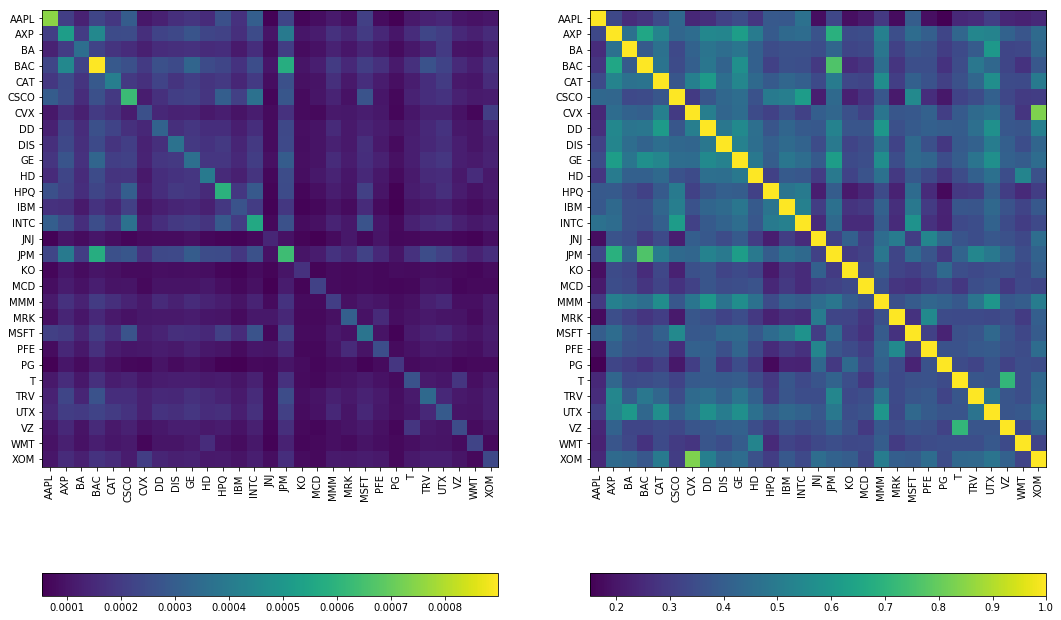

In [22]:
p = plt.figure(figsize=(18, 13))

ax = p.add_subplot(1,2,1)
plt.imshow(logret.cov())
plt.colorbar(orientation='horizontal')
ax.set_xticks(np.arange(0, 29, 1))
ax.set_yticks(np.arange(0, 29, 1))
ax.set_xticklabels(sigma.columns.values, rotation=90)
ax.set_yticklabels(sigma.columns.values)

ax = p.add_subplot(1,2,2)
plt.imshow(logret.corr())
plt.colorbar(orientation='horizontal')
ax.set_xticks(np.arange(0, 29, 1))
ax.set_yticks(np.arange(0, 29, 1))
ax.set_xticklabels(sigma.columns.values, rotation=90)
ax.set_yticklabels(sigma.columns.values)
plt.show(p)

In [23]:
import cvxpy as cvx

s, _ = sigma.shape

w = cvx.Variable(s)
risk = cvx.quad_form(w, sigma.values)
prob = cvx.Problem(cvx.Minimize(risk), 
               [cvx.sum(w) == 1])
prob.solve()
w.value

array([ 0.01948105, -0.06250038,  0.01187498, -0.0084919 , -0.02646181,
       -0.01481032,  0.09051826, -0.02578476, -0.00523808, -0.02671965,
       -0.01710607,  0.01275726,  0.12379533, -0.01863563,  0.23961134,
       -0.04051534,  0.1516256 ,  0.14640105,  0.09242141, -0.00409392,
        0.02276257,  0.02262697,  0.12819021,  0.0148031 ,  0.01603381,
       -0.00239166,  0.07525989,  0.11741913, -0.03283244])

Examples for portfolio optimization: http://nbviewer.jupyter.org/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb

Even though a much more difficult problem to solve, we can use `cvxpy` package to solve optimization problems easily. Let's try to solve the more difficult problem with a target expected return:

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mu^\intercal x\geq \mu^* \text{, and } \mathbf{1}^\intercal x = 1,$$

Note that in all of the above problems, the measure of $\mu^*$, expected returns, and covariance matrix have to be provided. In practice, these quantities are estimated from data.

In [24]:
import cvxpy as cvx

s,_ = sigma.shape

w = cvx.Variable(s)
risk = cvx.quad_form(w, sigma.values)
prob = cvx.Problem(cvx.Minimize(risk), 
               [
                   cvx.sum(w) == 1,
                   mu.values*w >= 0.001
               ])
prob.solve()
w.value

array([ 0.28292044, -0.08692003,  0.18889568, -0.11475068,  0.12405921,
       -0.14578946,  0.28568954, -0.15833925,  0.08717126, -0.40742057,
        0.01603534, -0.10958107,  0.0155148 , -0.09567277,  0.4877874 ,
        0.12581918,  0.02407474,  0.32872418,  0.40772487, -0.11240587,
       -0.00764719, -0.08230916,  0.07441161, -0.05895637,  0.12938975,
        0.08051488,  0.0551157 , -0.08624538, -0.24781079])

Verify that the solution satisfies the constraints: i.e. $\mu^\intercal w=0.001$ and $\mathbf{1}^\intercal w=1$.

In [25]:
w.value.sum()

1.0

In [26]:
np.dot(mu.values,w.value)

0.0009999999999999996

In [27]:
earned = np.dot(logret.fillna(method='bfill').values, w.value)
# f = plt.figure(figsize=(15,15))
# plt.plot((1+earned[1:]).cumprod())
# plt.show(f)

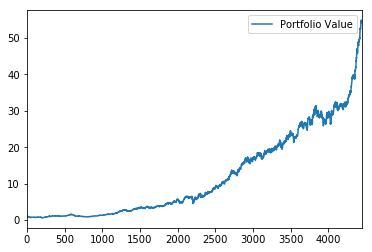

In [28]:
earnedcp = (1+earned[1:]).cumprod()
ecp = pd.DataFrame(earnedcp.T, columns=['Portfolio Value'])
ecp.plot();

### Reality check

Obviously, this cannot be realistic. What aspects were unrealistic?